## Воронка продаж продуктов мобильного приложения. А/А/В тест

### Описание проекта
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно? Исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

### План выполнения работы
#### Шаг 1. Изучение общей информации
#### Шаг 2. Подготовка данных
* Замена названия столбцов.
* Проверка данных на пропуски и оценка типов данных. 
* Добавление столбецов даты и времени, а также отдельного столбца дат.
#### Шаг 3. Изучение и проверка данных
* Сколько всего событий в логе?
* Сколько всего пользователей в логе?
* Сколько в среднем событий приходится на пользователя?
* Данными за какой период мы располагаем? Оценка максимальной и минимальной даты. Постройка гистограммы по дате и времени. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определение, с какого момента данные можно считать полными и отбросить более старые. Данными за какой период времени мы располагаем на самом деле?
* Много ли событий и пользователей мы потеряли, отбросив старые данные?
* Проверка, что у нас есть пользователи из всех трёх экспериментальных групп.
#### Шаг 4. Изучение воронки событий
* Определение, событий в логах, как часто они встречаются. Сортировка событий по частоте.
* Определение пользователей, совершавших каждое из этих событий. Сортировка событий по числу пользователей. Подсчет доли пользователей, которые хоть раз совершали событие.
* Определение, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
* Подсчет по воронке событий, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C подсчет отношения числа пользователей с событием B к количеству пользователей с событием A, а также отношения числа пользователей с событием C к количеству пользователей с событием B.
* На каком шаге теряется больше всего пользователей?
* Какая доля пользователей доходит от первого события до оплаты?
#### Шаг 5. Изучение результатов эксперимента
* Сколько пользователей в каждой экспериментальной группе?
* Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверка, находят ли статистические критерии разницу между выборками 246 и 247.
* Определение самого популярного события. Подсчет числа пользователей, совершивших это событие в каждой из контрольных групп. Подсчет доли пользователей, совершивших это событие. Проверка на наличие статистически достоверных отличий между группами. Проверка на наличие статистически достоверных отличий для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
* Аналогичная проверка  в группе с изменённым шрифтом. Сравнение результатов с каждой из контрольных групп в отдельности по каждому событию. Сравнение результатов с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
* Определение и обоснование уровеня значимости при проверке статистических гипотез. Подсчет количества проверок статистических гипотез. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

In [1]:
# импортирую библиотеки
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from scipy import stats as st 
import datetime as dt  
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
import math as mth

## Шаг 1. Изучение общей информации

In [2]:
# загружаю данные 
try:
    data = pd.read_csv(r"D:\DOCS\datasets\Сборный проект №2/logs_exp.csv", sep='\t')
except FileNotFoundError:
    data = pd.read_csv('/datasets/logs_exp.csv',sep='\t')

In [3]:
# вывожу первые 10 строк датафрейма
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


#### Описание данных
Каждая запись в логе — это действие пользователя, или событие. 
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Шаг 2. Подготовка данных

In [4]:
# вывожу информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
# переименовываю колонки
data.columns = ['event_name', 'userId', 'date_time', 'group']

In [6]:
# заменил числовые значения групп на A1- контрольная группа, А2 - контрольная группа, В - эксперементальная группа
data['group'] = data['group'].replace(246, 'A1')
data['group'] = data['group'].replace(247, 'A2')
data['group'] = data['group'].replace(248, 'B')

In [7]:
# вывожу количество пропусков в датафрейме
data.isna().sum()

event_name    0
userId        0
date_time     0
group         0
dtype: int64

In [8]:
# вывожу количество дубликатов в датафрейме
dup_count = data.duplicated().sum()
print('Количество дубликатов равно:', dup_count)

Количество дубликатов равно: 413


In [9]:
# выводу общее количество строк
count_row = data.shape[0]
print('Количество строк в датафрейме равно:', count_row)

Количество строк в датафрейме равно: 244126


In [10]:
# вывожу какой процент дубликаты составляют от общего количества строк
duplicated_procent = dup_count / count_row * 100
print('Процент дубликатов от общего количества строк составляет:',"{0:.3f}".format(duplicated_procent))

Процент дубликатов от общего количества строк составляет: 0.169


In [11]:
# удаляю дубликаты, их процент мал и не повлияет на дальнейший анализ
data = data.drop_duplicates()

In [12]:
# сбрасываю индексы
data = data.reset_index(drop=True)

In [13]:
# преобразую значения столбца date_time к формату datetime
data['date_time'] = pd.to_datetime(data['date_time'], unit='s')

In [14]:
# создаю столбец date, который будет включать только дату события
data['date'] = data['date_time'].dt.date

In [15]:
# Check
data.head(5)

,event_name,userId,date_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


In [16]:
# преобразую столбец date к формату datetime
data['date'] = pd.to_datetime(data['date'])

In [17]:
# Check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   userId      243713 non-null  int64         
 2   date_time   243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 9.3+ MB


In [18]:
# Check
data.duplicated().sum()

0

In [19]:
# Check
data.isna().sum()

event_name    0
userId        0
date_time     0
group         0
date          0
dtype: int64

In [20]:
# выделил группы пользователей
a1_group = data[data['group'] == 'A1']
a2_group = data[data['group'] == 'A2']
b_group = data[data['group'] == 'B']

In [21]:
# соединил полученные группы пользователей по userId
coincid = pd.merge(a1_group, a2_group, on=['userId'], how='inner')
print('Количество совпадений пользователей в группах А1, A2 составляет:', coincid['userId'].nunique())

Количество совпадений пользователей в группах А1, A2 составляет: 0


In [22]:
coincid_1 = pd.merge(a1_group, b_group, on=['userId'], how='inner')
print('Количество совпадений пользователей в группах А1, B составляет:',coincid_1['userId'].nunique())

Количество совпадений пользователей в группах А1, B составляет: 0


In [23]:
coincid_2 = pd.merge(a2_group, b_group, on=['userId'], how='inner')
print('Количество совпадений пользователей в группах А2, B составляет:',coincid_1['userId'].nunique())

Количество совпадений пользователей в группах А2, B составляет: 0


### Вывод по итогу подготовки данных:
* Датафрейм data содержит 4 колонки: EventName — название события; DeviceIDHash — уникальный идентификатор пользователя; EventTimestamp — время события ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
* Выполнено переименование столбцов датафрейма.
* Выполнена проверка на пропуски. Пропусков не вывлено.
* Выполнена проверка на дубликаты. Выявлено 413 строк-дубликатов, что составляет 0,169% от общего числа строк. Так как процент дубликатов мал, их удаление не повлияет на дальнейший анализ. Решено их удалить.
* Выполнена замена числовых значений групп на A1- контрольная группа, А2 - контрольная группа, В - эксперементальная группа
* Выполнено преобразование столбеца date_time к формату datetime.
* Добавлен столбец date, который будет включать только дату события.
* Выполнено преобразование столбеца date к формату datetime.
* Совпадений userId пользователей в группах не выявлено.

## Шаг 3. Изучение и проверка данных

In [24]:
print('Всего событий в логе:', data['event_name'].count())
print('Уникальных событий в логе:', data['event_name'].nunique())

Всего событий в логе: 243713
Уникальных событий в логе: 5


In [25]:
print('Всего пользователей в логе:', data['userId'].nunique())

Всего пользователей в логе: 7551


In [26]:
avg_events = data['event_name'].count() // data['userId'].nunique()
print('Среднее количество событий на пользователя равно:', avg_events)

Среднее количество событий на пользователя равно: 32


In [27]:
event_per_user = data.groupby('userId')['event_name'].count()
event_per_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

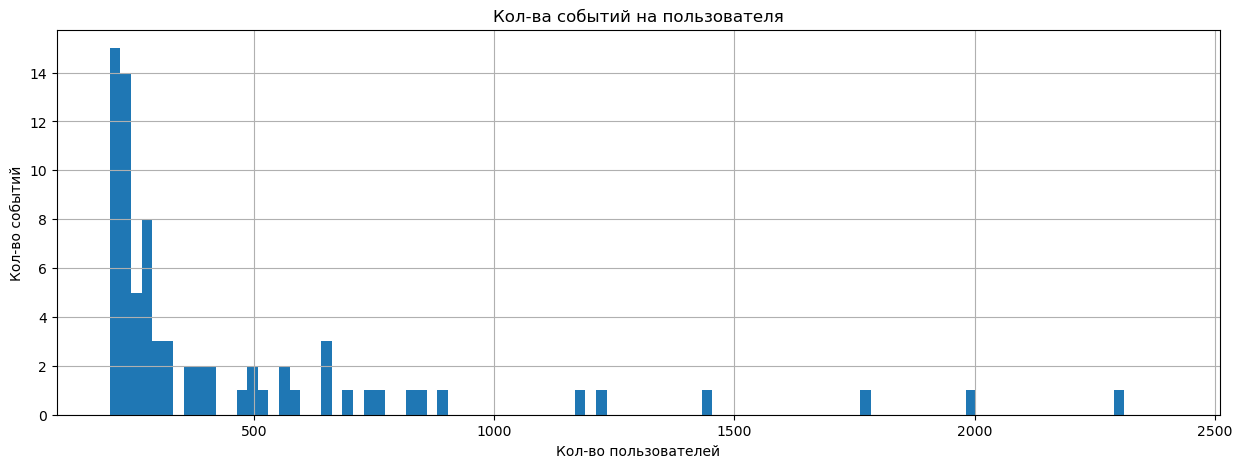

In [28]:
plt.figure(figsize=(15,5))
plt.hist(event_per_user, bins=100, range=(200,2400)) 
plt.xlabel('Кол-во пользователей')
plt.grid()
plt.ylabel('Кол-во событий')
plt.title('Кол-ва событий на пользователя');

In [29]:
event_per_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

* В данных наблюдаются выбросы. Есть пользователи, количество событий с которыми более 2300. В таком случае более показательным будет медианное значение, так как оно не подвержено выбросам.

In [30]:
print('Медианное значение событий на пользователя равно:', event_per_user.median())

Медианное значение событий на пользователя равно: 20.0


In [31]:
print('Дата начала исследования:', data['date'].dt.date.min())
print('Дата окончания исследования:', data['date'].dt.date.max())
print('Всего дней исследования:', (data['date'].dt.date.max() - data['date'].dt.date.min()).days)

Дата начала исследования: 2019-07-25
Дата окончания исследования: 2019-08-07
Всего дней исследования: 13


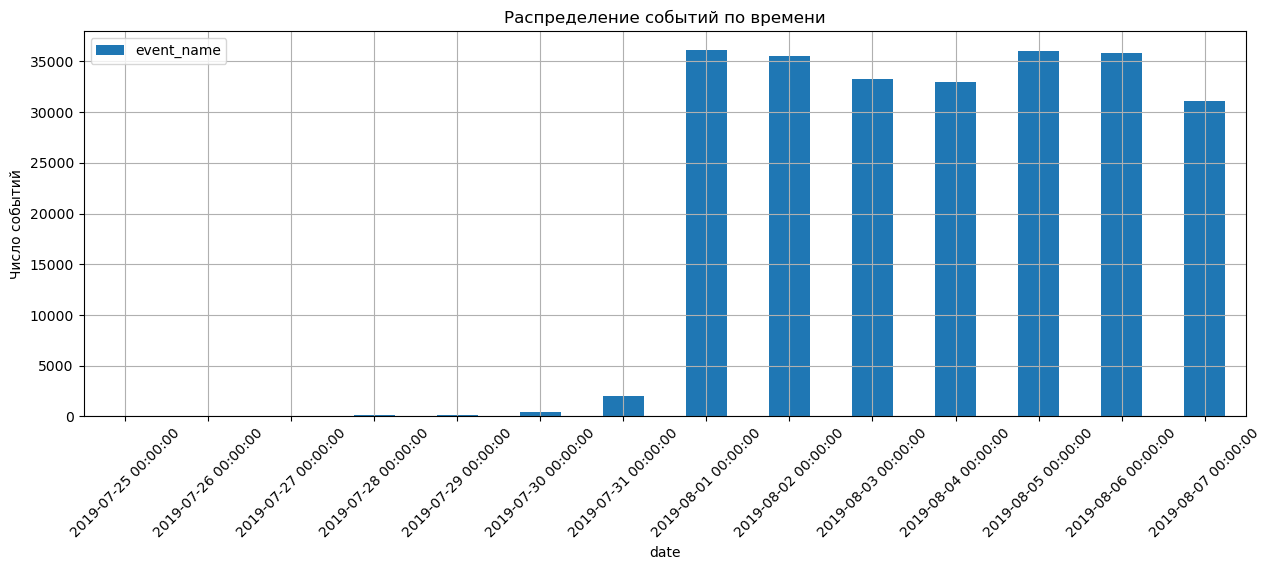

In [32]:
# Строю график распределения событий по датам
data.groupby('date').agg({'event_name':'count'}).plot(kind='bar', grid=True, figsize=(15,5))
plt.xticks(rotation=45)
plt.ylabel('Число событий')
plt.title('Распределение событий по времени')
plt.show()

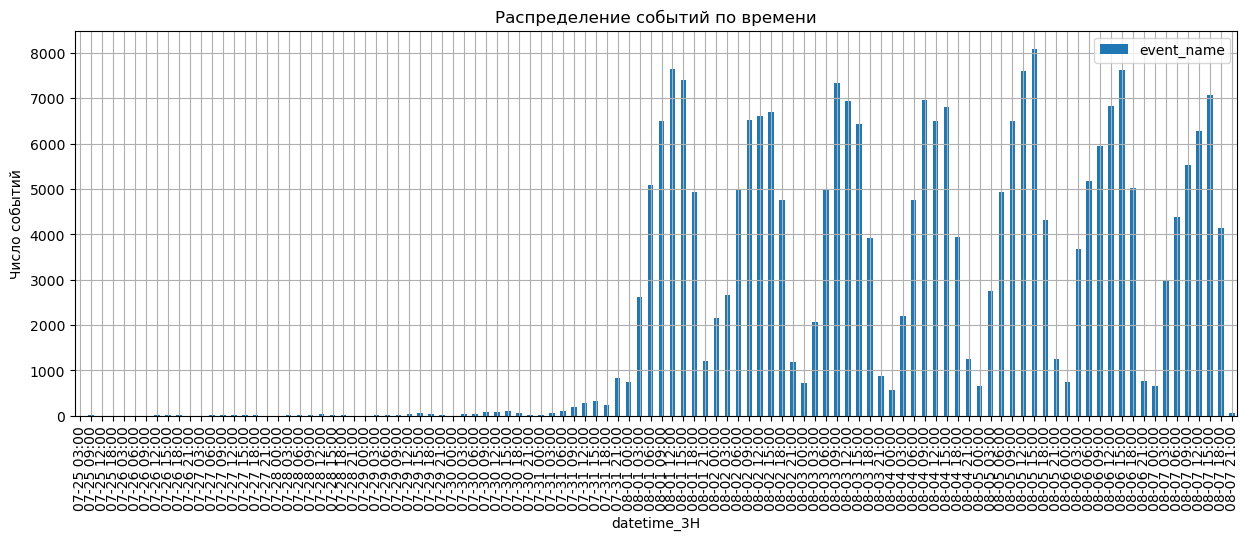

In [33]:
# Строю график распределения событий по датам и времени
data_for_plot = (data.assign(datetime_3H = lambda x: x['date_time'].dt.floor('3H').dt.strftime('%m-%d %H:%M'))
                .groupby('datetime_3H').agg({'event_name':'count'}).reset_index())
data_for_plot.plot(kind='bar', x='datetime_3H', y='event_name', grid=True, figsize=(15,5))
plt.xticks(rotation=90)
plt.ylabel('Число событий')
plt.title('Распределение событий по времени')
plt.show()

In [34]:
# строю таблицу распределения событий по датам
data_pivot = data.pivot_table(index=['date'],columns='event_name',values='userId',aggfunc='count')
data_pivot 

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
date,,,,,
2019-07-25,2.0,4.0,1.0,2.0,NaN
2019-07-26,6.0,16.0,4.0,3.0,2.0
2019-07-27,4.0,39.0,9.0,1.0,2.0
2019-07-28,24.0,53.0,16.0,12.0,NaN
2019-07-29,23.0,132.0,20.0,9.0,NaN
2019-07-30,49.0,279.0,51.0,33.0,NaN
2019-07-31,257.0,1250.0,374.0,140.0,9.0
2019-08-01,6217.0,17945.0,6988.0,4771.0,220.0
2019-08-02,6522.0,16792.0,6924.0,5148.0,168.0


#### По гистограмме и таблице можно сделать вывод о том, что наиболее полные данные поступили с 21.00 31.07.2019. Срез данных в дальнейшем буду проводить по этой границе

In [35]:
# сделал срез событий, которые не будут входить в данные для дальнейшего анализа
old_events = data.loc[data['date_time']<='2019-07-31 21:00:00']

In [36]:
# сделал срез актуальных данных
new_data = data.loc[data['date_time']>'2019-07-31 21:00:00']

In [37]:
# выделил в отдельную таблицу логи пользователей, которые совершали действия до 21:00 2019-07-31
old_users = old_events[~old_events['userId'].isin(new_data['userId'])]

In [38]:
print('Количество записей событий до отчистки:', len(data['event_name']))
print('Количество удаленных событий:', len(old_events['event_name']))
print('Количество записей событий после отчистки:', len(data['event_name']) - len(old_events['event_name']))
print('Процент потери составил:', "{0:.2%}".format(len(old_events['event_name']) /  len(data['event_name'])))

Количество записей событий до отчистки: 243713
Количество удаленных событий: 1989
Количество записей событий после отчистки: 241724
Процент потери составил: 0.82%


In [39]:
print('Всего уникальных пользователей в логе до отчистки:', len(data['userId'].unique()))
print('Количество потерянных пользователей:', old_users['userId'].nunique())
print('Всего уникальных пользователей в логе после отчистки:', (data['userId'].nunique() - old_users['userId'].nunique()))
print('Процент потери пользователей составил:',"{0:.2%}".format(len(old_users['userId'].unique()) / len(data['userId'].unique())))

Всего уникальных пользователей в логе до отчистки: 7551
Количество потерянных пользователей: 13
Всего уникальных пользователей в логе после отчистки: 7538
Процент потери пользователей составил: 0.17%


In [40]:
data = data.loc[data['date_time']>'2019-07-31 21:00:00']

In [41]:
# Сгруппировал события по  исследуемым группам, по результатам события в соизмеримом количестве есть во всех трех группах
data.groupby('group')['event_name'].count()

group
A1    79556
A2    77293
B     84875
Name: event_name, dtype: int64

In [42]:
# Сгруппировал ID пользователей по исследуемым группам, по результатам пользователи в соизмеримом количестве
# есть во всех трех группах
data.groupby('group')['userId'].nunique()

group
A1    2484
A2    2517
B     2537
Name: userId, dtype: int64

### Вывод по итогу изучения и проверки данных
* После исследования выявлено Дата начала исследования: 2019-07-25 Дата окончания исследования: 2019-08-07 Всего дней исследования: 13
* Наиболее полные данные начали поступать после 21:00 2019-07-31. Дальнейшее исследование решено проводить на данных после 2019-07-31 21:00
* Количество записей событий до отчистки: 243713. Количество удаленных событий - 1989. Количество записей событий после отчистки: 241724. Процент потери составил: 0.82%
* Всего уникальных пользователей в логе до отчистки: 7551. Количество потерянных пользователей: 13. Всего уникальных пользователей в логе после отчистки: 7538. Процент потери составил: 0.17%
* Определено, что в полученном после среза  датафрейме во всех трех исследуемых группах осталось соизмеримое количество событий и пользователей. 

## Шаг 4. Изучение воронки событий

In [43]:
# вывел количество каждого события с сортировкой от большего к меньшему
data['event_name'].value_counts()

MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Tutorial                     1010
Name: event_name, dtype: int64

#### События в порядке убывания количества расположились в порядке:
* Появление главного экрана
* Появление экрана предложений
* Появление экрана корзины
* Появление сообщения об успешной оплате
* Обучение
#### Думаю что обучение не входит полный цикл использования сайта. Его пропускают многие пользователи знакомые с интерфейсом. Обучение может игнорироваться большим количеством пользователей сайта.

In [44]:
# решил исключть tutorial из дальнейшего анализа
data = data[data['event_name'] != 'Tutorial']

In [61]:
# Создаю таблицу в которой уникальные пользователи будут сортрованы по совершенным на сайте дествиям.
# По таблице видно, что большое количество пользователей всех групп не доходят до экрана предложений
data_ev_pivot = (data.pivot_table(index='event_name',values='userId',aggfunc='nunique')
                    .sort_values(by='userId', ascending=False))
# добавляю к таблице котонку percent. Она показывает, какой процент уникальных пользователей от всех пользователей 
# переходит на сайте к следующему этапу
data_ev_pivot['percent'] = data_ev_pivot['userId'] / data['userId'].nunique()*100
data_ev_pivot['percent'] = round(data_ev_pivot['percent'],2)
# добавляю к таблице колонку pass_percent. Она показывает, какой процент от пользователей у которых появился главный экран,
# перешел от предыдущего этапа к последующему 
data_ev_pivot['pass_percent'] = data_ev_pivot['userId'].pct_change()*100
data_ev_pivot['pass_percent'] = 100 + round(data_ev_pivot['pass_percent'],2)
# заполнил пропуск в pass_percent, в строке MainScreenAppear значением 100, так как подсчет вел от числа пользователей
# у которых появился главный экран
data_ev_pivot = data_ev_pivot.fillna(data_ev_pivot['userId'] / data['userId'].nunique()*100)
# выделил названия эвентов в отдельную колонку
data_ev_pivot = data_ev_pivot.reset_index()
data_ev_pivot

,event_name,userId,percent,pass_percent
0,MainScreenAppear,7423,98.53,NaN
1,OffersScreenAppear,4597,61.02,61.93
2,CartScreenAppear,3736,49.59,81.27
3,PaymentScreenSuccessful,3540,46.99,94.75


In [63]:
# Построил воронку процента прохождения к последующему этапу от общего количества пользователей
fig = go.Figure(go.Funnel(
    y = data_ev_pivot['event_name'],
    x = data_ev_pivot['userId'],
    textposition = "inside",
    textinfo = "value+percent initial"
    ))
fig.show()

#### По данной воронке мы видим, что с главного экрана на экран предложений переходит 61,9% пользователей от общего числа. Больщое количество пользователей, а точнее 38,1% от общего числа пользователей, теряются именно на этом этапе.  50,3% от числа открывших приложение пользователей, переходят на станицу корзины.Экран успешной оплаты появляется у 47,7% пользователей от общего числа пользователей.

### Вывод по итогу изучения воронки событий
* В логах мы имеем 5 типов событий MainScreenAppear(Появление главного экрана)-117889, OffersScreenAppear(Появление экрана предложений)-46531, CartScreenAppear(Появление экрана корзины)-42343, PaymentScreenSuccessful(Появление сообщения об успешной оплате)-33951, Tutorial(Обучение)-1010. Tutorial пропускают многие пользователи знакомые с интерфейсом. Обучение может игнорироваться большим количеством пользователей сайта. Принял решение исключить его из дальшейшей визуальзации.
* С главного экрана на экран предложений переходит 61,9% пользователей от общего числа. Больщое количество пользователей, а точнее 38,1% от общего числа пользователей, теряются именно на этом этапе.  50,3% от числа открывших приложение пользователей, переходят на станицу корзины.Экран успешной оплаты появляется у 47,7% пользователей от общего числа пользователей.
* От первого события до оплаты доходит 45,52% пользователей. У 1,47% пользователей не произошло регистрации первого события.

## Шаг 5. Изучение результатов эксперимента

In [49]:
# вывел количество уникальных пользователей каждой из групп
users_grouped = data.groupby('group')['userId'].nunique()
users_grouped['A1+A2'] = users_grouped['A1'] + users_grouped['A2']
users_grouped = users_grouped.reset_index()
users_grouped

,group,userId
0,A1,2483
1,A2,2516
2,B,2535
3,A1+A2,4999


In [50]:
# создал таблицу с разделением уникальных пользователей по группам и по событиям
data_pivot = (data.pivot_table(index=['event_name'],columns='group', values = 'userId',aggfunc='nunique')
           .sort_values(by='A1', ascending=False))
data_pivot = data_pivot.reset_index()
data_pivot['A1+A2'] = data_pivot['A1'] + data_pivot['A2']
data_pivot

group,event_name,A1,A2,B,A1+A2
0,MainScreenAppear,2450,2479,2494,4929
1,OffersScreenAppear,1542,1524,1531,3066
2,CartScreenAppear,1266,1239,1231,2505
3,PaymentScreenSuccessful,1200,1158,1182,2358


In [51]:
# выделил количество уникальных пользователей каждой из групп
a1_group = data[data['group'] == 'A1']['userId'].nunique()
a2_group = data[data['group'] == 'A2']['userId'].nunique()
b_group = data[data['group'] == 'B']['userId'].nunique()

In [52]:
# вывел процент прохождения пользователями групп к последующим этапам от общего числа пользователей групп
data_pivot['percent_A1'] = round(data_pivot['A1'] / a1_group * 100,2)
data_pivot['percent_A2'] = round(data_pivot['A2'] / a2_group * 100,2)
data_pivot['percent_B'] = round(data_pivot['B'] / b_group * 100,2)
data_pivot['percent_A1+A2'] = round(data_pivot['A1+A2'] / (a1_group + a2_group) * 100,2)

In [53]:
# вывел процент прохождени я пользователями групп к последующим этапам от числа пользоватей групп, прошедших предыдущий этап
data_pivot['pass_percent_A1'] = data_pivot['A1'].pct_change()*100
data_pivot['pass_percent_A1'] = 100 + round(data_pivot['pass_percent_A1'],2) 
data_pivot['pass_percent_A2'] = data_pivot['A2'].pct_change()*100
data_pivot['pass_percent_A2'] = 100 + round(data_pivot['pass_percent_A2'],2) 
data_pivot['pass_percent_B'] = data_pivot['B'].pct_change()*100
data_pivot['pass_percent_B'] = 100 + round(data_pivot['pass_percent_B'],2) 
data_pivot['pass_percent_A1+A2'] = data_pivot['A1+A2'].pct_change()*100
data_pivot['pass_percent_A1+A2'] = 100 + round(data_pivot['pass_percent_A1+A2'],2) 
data_pivot = data_pivot.fillna(100)
data_pivot

group,event_name,A1,A2,B,A1+A2,percent_A1,percent_A2,percent_B,percent_A1+A2,pass_percent_A1,pass_percent_A2,pass_percent_B,pass_percent_A1+A2
0,MainScreenAppear,2450,2479,2494,4929,98.67,98.53,98.38,98.60,100.00,100.00,100.00,100.00
1,OffersScreenAppear,1542,1524,1531,3066,62.10,60.57,60.39,61.33,62.94,61.48,61.39,62.20
2,CartScreenAppear,1266,1239,1231,2505,50.99,49.24,48.56,50.11,82.10,81.30,80.40,81.70
3,PaymentScreenSuccessful,1200,1158,1182,2358,48.33,46.03,46.63,47.17,94.79,93.46,96.02,94.13


In [54]:
# Построил воронку числа и процента прохождения к последующему этапу от предыдцщего в разбивке по группам
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A1',
    y = data_pivot['event_name'],
    x = data_pivot['A1'],
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'A2',
    orientation = "h",
    y = data_pivot['event_name'],
    x = data_pivot['A2'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = 'B',
    orientation = "h",
    y =  data_pivot['event_name'],
    x = data_pivot['B'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.show()

#### Данная воронка отражает процент прохождения пользователей от предыдущего к последующему этапу в разбивке по группам. Наименьший процент успешного прохождения во всех группах имеет этап OffersScreenAppear. Именно здесь уходит большое количество пользователей в группе А1-37%, А2-39%, В-39%.

In [55]:
def z_test(actA,actB,groupA,groupB, eventname,alpha):
    
    p1 = actA/groupA
    p2 = actB/groupB

    p_combined = (actA + actB) / (groupA + groupB)
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/groupA + 1/groupB))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value =(1 - distr.cdf(abs(z_value))) * 2

    print(f'{eventname} p-значение: ', p_value)
    
    bonferroni_alpha =   alpha / 16

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print('**************')

#### Провожу А/А- тест. Проверка гипотезы о равенстве долей пользователей перешедших на этап взаимодействия с сайтом от общего числа уникальных пользователей группы в группах А1 и А2

#### Формулирую гипотезы
* H0 Доли уникальных посетителей, побывавших на этапе воронки, одинаковы.
* H1 Между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

In [56]:
AAtest = [z_test(data_pivot['A1'][i],data_pivot['A2'][i],users_grouped['userId'][0],users_grouped['userId'][1],data_pivot['event_name'][i],alpha = .05)
        for i in range(len(data_pivot['A1']))]

MainScreenAppear p-значение:  0.6702082653142836
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
OffersScreenAppear p-значение:  0.2667347868697105
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
CartScreenAppear p-значение:  0.21811883651016095
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
PaymentScreenSuccessful p-значение:  0.10288527362638322
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************


#### Провожу А/B- тест. Проверка гипотезы о равенстве долей пользователей перешедших на этап взаимодействия с сайтом от общего числа уникальных пользователей  группы в группах А1 и B

In [57]:
# А/В тест для групп А1 и В
A1Btest = [z_test(data_pivot['A1'][i],data_pivot['B'][i],users_grouped['userId'][0],users_grouped['userId'][2],data_pivot['event_name'][i],alpha = .05)
        for i in range(len(data_pivot['A1']))]

MainScreenAppear p-значение:  0.396910049618151
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
OffersScreenAppear p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
CartScreenAppear p-значение:  0.08564271892834707
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
PaymentScreenSuccessful p-значение:  0.22753674585530037
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************


#### Провожу А/B- тест. Проверка гипотезы о равенстве долей пользователей перешедших на этап взаимодействия с сайтом от общего числа уникальных пользователей  группы в группах А2 и B

In [58]:
# А/В тест для групп А2 и В
A2Btest = [z_test(data_pivot['A2'][i],data_pivot['B'][i],users_grouped['userId'][1],users_grouped['userId'][2],data_pivot['event_name'][i],alpha = .05)
        for i in range(len(data_pivot['A1']))]

MainScreenAppear p-значение:  0.6723167704766229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
OffersScreenAppear p-значение:  0.8971376549155397
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
CartScreenAppear p-значение:  0.6264599792848009
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
PaymentScreenSuccessful p-значение:  0.6680367850275775
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************


#### Провожу А/B- тест. Проверка гипотезы о равенстве долей пользователей перешедших на этап взаимодействия с сайтом от общего числа уникальных пользователей группы в общей контрольной группе А1+А2 и эксперементальной группе В

In [59]:
# А/В тест для групп A1 + А2 и В
A1A2Btest = [z_test(data_pivot['A1+A2'][i],data_pivot['B'][i],users_grouped['userId'][3],users_grouped['userId'][2],data_pivot['event_name'][i],alpha = .05)
        for i in range(len(data_pivot['A1']))]

MainScreenAppear p-значение:  0.4599468774918498
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
OffersScreenAppear p-значение:  0.4303431159342346
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
CartScreenAppear p-значение:  0.20361356481451098
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************
PaymentScreenSuccessful p-значение:  0.6559128929243401
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
**************


#### При принятии уровня статистической значимости 0.05 в 5 % случаев мы можем получить ошибку 1 рода- выявление значимых различий в двух генеральных совокупностях при отсутствии таковых. Для того, чтлбы снизить риск ошибки применена поправка Бонферрони: уровень статистической значимости разделен на количество проведенных проверок гипотез. Всего проверено  16 гипотез

### Вывод по итогу изучения результатов эксперимента.
* Количество уникальных пользователей в группах составило: A1-2483, A2-2516, B-2535, в объединенной контрольной группе(A1+A2)-4999 пользователей.
* Проведен А/А тест.  Проверка гипотезы о равенстве долей пользователей перешедших на этап взаимодействия с сайтом от общего числа пользователей в группах А1 и А2. При проведении А/А теста был задан уровень статистической значимости alpha = .05. По результатам проверки pначимых различий в долях групп не выявлно.
* Подсчитано кроличество уникальных пользователей в разбивке по группам, совершивших каждое событие, подсчитан процент прохождения пользователями групп к последующим этапам от общего числа пользователей групп. подсчитан процент прохождения пользователями групп к последующим этапам от числа пользоватей групп, прошедших предыдущий этап.
* Проведен А/В тест. Проверка гипотезы о равенстве долей успешно перешедших на этап использования сайта от общего числа уникальных пользователей группы. Исследованы группы А1/В- значимых различий в долях групп не выявлено А2/В- значимых различий в долях групп не выявлено А1+А2/ В- значимых различий в долях групп не выявлено. При проведении А/В теста был задан уровень статистической значимости alpha = .05. В связи с тем, что проводилось множественное сравнение долей генеральных совокупностей с целью снижения появления ошибкии 1 рода применена поправка Бонферрони. По результатам 12 проверок значимых различий в долях групп не выявлно. А/В тест можно считать завершенным, положительным. Изменение шрифта не повлияло на поведение пользователей.

## Общий вывод

### По итогу подготовки данных:
* Датафрейм data содержит 4 колонки: EventName — название события; DeviceIDHash — уникальный идентификатор пользователя; EventTimestamp — время события ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
* Выполнено переименование столбцов датафрейма.
* Выполнена проверка на пропуски. Пропусков не вывлено.
* Выполнена проверка на дубликаты. Выявлено 413 строк-дубликатов, что составляет 0,169% от общего числа строк. Так как процент дубликатов мал, их удаление не повлияет на дальнейший анализ. Решено их удалить.
* Выполнена замена числовых значений групп на A1- контрольная группа, А2 - контрольная группа, В - эксперементальная группа
* Выполнено преобразование столбеца date_time к формату datetime.
* Добавлен столбец date, который будет включать только дату события.
* Выполнено преобразование столбеца date к формату datetime.
### По итогу изучения и проверки данных:
* После исследования выявлено Дата начала исследования: 2019-07-25 Дата окончания исследования: 2019-08-07 Всего дней исследования: 13
* Наиболее полные данные начали поступать после 21:00 2019-07-31. Дальнейшее исследование решено проводить на данных после 2019-07-31 21:00
* Количество записей событий до отчистки: 243713. Количество удаленных событий - 1989. Количество записей событий после отчистки: 241724. Процент потери составил: 0.82%
* Всего уникальных пользователей в логе до отчистки: 7551. Количество потерянных пользователей: 13. Всего уникальных пользователей в логе после отчистки: 7538. Процент потери составил: 0.17%
* Определено, что в полученном после среза  датафрейме во всех трех исследуемых группах осталось соизмеримое количество событий и пользователей. 
### По итогу изучения воронки событий:
* В логах мы имеем 5 типов событий MainScreenAppear(Появление главного экрана)-117889, OffersScreenAppear(Появление экрана предложений)-46531, CartScreenAppear(Появление экрана корзины)-42343, PaymentScreenSuccessful(Появление сообщения об успешной оплате)-33951, Tutorial(Обучение)-1010. Tutorial пропускают многие пользователи знакомые с интерфейсом. Обучение может игнорироваться большим количеством пользователей сайта. Принял решение исключить его из дальшейшей визуальзации.
* Появление главного экрана происходит у 98,53% пользователей от общего числа пользователей. Переходят на станицу корзины 49,59% от числа открывших приложение пользователей.Экран успешной оплаты появляется у 46,99% пользователей от общего числа пользователей. Большой проццент пользователей теряется на этапе перехода к предолжениям. Он составляет 38,98% от общего числа пользователей.
* Процент пользователей, перешедших с главного экрана на экран предложений составляет 61,93%. Процент перешедших к корзине, от просмотревших предолжения пользвателей составляет 81,27%. К успешной оплате переходит 94,75 % от просмотревших корзину. На этапе OffersScreenAppear уходит большое количество пользователей - 38,07%. На дальнейших этапах сильных просадок не выявлено.
* От первого события до оплаты доходит 45,52% пользователей. У 1,47% пользователей не произошло регистрации первого события.
### По итогу изучения результатов эксперимента:
* Количество уникальных пользователей в группах составило: A1-2483, A2-2516, B-2535, в объединенной контрольной группе(A1+A2)-4999 пользователей.
* Проведен А/А тест. Проверка гипотезы о равенстве долей успешно оплативших товар пользователей от пользователей, перешедших на страницу корзины в группах А1 и А2 равны. H0 Доля успешно оплативших товар пользователей от пользователей, перешедших на страницу корзины в группе A1 равна соответствующей доле пользователей в группе A2. H1 Доля успешно оплативших товар пользователей от пользователей, перешедших на страницу корзины в группе A1 не равна соответствующей доле пользователей в группе A2.При проведении А/А теста был задан уровень статистической значимости alpha = .01. По результатам проверки H0 отвергнуть не удолось. Значимых различий в долях групп не выявлно.
* Подсчитано кроличество уникальных пользователей в разбивке по группам, совершивших каждое событие, подсчитан процент прохождения пользователями групп к последующим этапам от общего числа пользователей групп. подсчитан процент прохождени я пользователями групп к последующим этапам от числа пользоватей групп, прошедших предыдущий этап.
* Проведен А/В тест. Проверка гипотезы о равенстве долей успешно перешедших на последующий этап от пользователей, предущего этапа. Исследованы группы А1/В- значимых различий в долях групп не выявлено А2/В- значимых различий в долях групп не выявлено А1+А2/ В- значимых различий в долях групп не выявлено. При проведении А/В теста был задан уровень статистической значимости alpha = .05. В связи с тем, что проводилось множественное сравнение долей генеральных совокупностей с целью снижения появления ошибкии 1 рода применена поправка Бонферрони. По результатам 12 проверок значимых различий в долях групп не выявлно. 
### А/В тест можно считать завершенным, положительным. Изменение шрифта не повлияло на поведение пользователей.